In [203]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback

In [204]:
def generate_random_coordinates(x_min, x_max, y_min, y_max, n=1, threshold=0.08):
    """
    Generate random (x, y) coordinates within specified bounds, ensuring no two points are closer than the threshold.

    Parameters:
    - n: int, number of coordinates to generate
    - x_min: float, minimum value for x coordinates
    - x_max: float, maximum value for x coordinates
    - y_min: float, minimum value for y coordinates
    - y_max: float, maximum value for y coordinates
    - threshold: float, minimum Euclidean distance between any two points

    Returns:
    - coordinates: array of shape (n, 2) containing generated (x, y) coordinates
    """
    coordinates = []

    while len(coordinates) < n:
        # Generate a new candidate point
        x_new = np.random.uniform(x_min, x_max)
        y_new = np.random.uniform(y_min, y_max)
        new_point = np.array([x_new, y_new])

        # Check distance to all existing points
        if all(
            np.linalg.norm(new_point - existing_point) > threshold
            for existing_point in coordinates
        ):
            coordinates.append(new_point)

    return np.array(coordinates)

In [225]:
def calculate_distance(point1, point2,abs=True):
    # Convert points to NumPy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)

    # Calculate the distance
    distance = np.linalg.norm(point1 - point2)

    return np.abs(distance) if abs else distance


pass

In [206]:
def calculate_movement(v1, v2, L, delta_t):
    # Calculate forward distance
    d = (v1 + v2) / 2 * delta_t

    # Calculate angular velocity
    omega = (v2 - v1) / L

    # Calculate change in orientation
    delta_theta = omega * delta_t

    return d, delta_theta

In [207]:
def get_alignment_to_target(orientation, current_coordinate, destination_coordinate):
    theta = np.arctan2(
        destination_coordinate[1] - current_coordinate[1],
        destination_coordinate[0] - current_coordinate[0],
    )

    return np.degrees(theta) - orientation

In [208]:
class RobotBase:

    position: list[float]
    orientation: float = 0
    speed: float = 1
    angular_speed = 10
    obstacle_threshold = 1
    id: int

    def __init__(
        self,
        id: int,
        initial_position,
        orientation=0,
        speed: float = 1,
        angular_speed=10,
        obstacle_threshold=1,
    ):
        self.id = id
        self.position = initial_position
        self.orientation = orientation
        self.speed = speed
        self.angular_speed = angular_speed
        self.obstacle_threshold = obstacle_threshold

    @property
    def x(self):
        return self.position[0]

    @property
    def y(self):
        return self.position[1]

    @x.setter
    def x(self, v):
        self.position[0] = v

    @y.setter
    def y(self, v):
        self.position[1] = v

    def forward(self):
        pass

    def stop(self):
        pass

    def turn_left(self):
        pass

    def turn_right(self):
        pass

    def detect_obstacles(self):
        pass

    def move(self, left_velocity, right_velocity):
        pass

    def is_out_of_range(self):
        pass


pass

In [209]:
class AgentBase(gym.Env):

    def reset(self, *args, **kwargs):
        pass

    def render(self):
        pass

    def close(self):
        pass

    def step(self, action):
        pass


pass

In [210]:
def plot_env(grid_size, robot: RobotBase = None, target=None, ax=None, targets=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.grid(True)

    if target is not None:
        ax.plot(
            target[0],
            target[1],
            "gx",
            label="Target",
            markersize=10,
        )

    if targets is not None:
        ax.plot(
            targets[:,0],
            targets[:,1],
            "go",
            label="Target",
            markersize=5,
        )

    if robot is not None:

        length = 1
        O_radians = np.deg2rad(robot.orientation)
        x, y = robot.x, robot.y
        x_end = x + length * np.cos(O_radians)
        y_end = y + length * np.sin(O_radians)

        ax.plot(
            x,
            y,
            "bo",
            label="Robots",
            markersize=10,
        )

        # Plot the arrow indicating the direction
        ax.quiver(
            x,
            y,
            x_end - x,
            y_end - y,
            angles="xy",
            scale_units="xy",
            scale=1,
            color="r",
        )
    ax.set_aspect("equal")
    ax.legend()
    return ax


pass

In [211]:
class RobotContinuous(RobotBase):
    occupancy_grid: np.array
    grid_size: list[float]
    _is_out_of_range = False

    def __init__(
        self,
        id: int,
        grid_size: list[float],
        initial_position,
        orientation=0,
        speed=1,
        angular_speed=10,
        obstacle_threshold=1,
        aperture=120,
        axial_distance=1,
        basic_timestep=1,
    ):
        super().__init__(
            id,
            initial_position,
            orientation,
            speed,
            angular_speed=angular_speed,
        )
        self.grid_size = grid_size
        self.obstacle_threshold = obstacle_threshold
        self.aperture = aperture
        self.axial_distance = axial_distance
        self.basic_timestep = basic_timestep

    def detect_obstacles(self):
        pass

    def is_out_of_range(self):
        return self._is_out_of_range

    def move(self, left, right):
        left_velocity, right_velocity = self.speed * left, self.speed * right

        distance, orientation_change = calculate_movement(
            left_velocity,
            right_velocity,
            self.axial_distance,
            self.basic_timestep,
        )

        O_radians = orientation_change + np.radians(self.orientation)

        x_new = self.x + distance * np.cos(O_radians)
        y_new = self.y + distance * np.sin(O_radians)

        self.x = x_new
        self.y = y_new
        self.orientation = np.degrees(O_radians)
        if (
            x_new >= self.grid_size[0]
            or y_new >= self.grid_size[1]
            or x_new < 0
            or y_new < 0
        ):
            # print(f"Robot {self.id} out of bounds")
            self._is_out_of_range = True
            return False

        self._is_out_of_range = False

In [212]:
class RenderCallback(BaseCallback):
    def __init__(self, env, verbose=0):
        super(RenderCallback, self).__init__(verbose)
        self.env = env

    def _on_step(self) -> bool:
        self.env.render()
        return True

    def _on_training_end(self) -> None:
        self.env.close()

In [213]:
class TurnToTargetAgentV1(AgentBase):

    robot: RobotBase
    target_pos: list = [0, 0]
    initial_position = [0, 0]
    initial_orientation = 0
    plot = None
    agent_type = None

    def __init__(
        self,
        robot: RobotBase,
        target_pos: list,
        grid_size,
        should_render=True,
    ):
        self.robot = robot
        self.should_render = should_render

        self.target_pos = target_pos

        self.initial_position = [robot.x, robot.y]
        self.initial_orientation = robot.orientation
        self.grid_size = grid_size

        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.screen = None

        self.observation_space = gym.spaces.Box(
            low=np.array([-1]),
            high=np.array([1]),
            shape=(1,),
            dtype=np.float32,
        )

        self.action_space = gym.spaces.Box(
            low=np.array([0, 0]),
            high=np.array([1, 1]),
            shape=(2,),
            dtype=np.float32,
        )

        self.render_tag = ""

    def reset(self, *args, **kwargs):
        training_angles = [0, 45, 90, 135, 180, 180 + 45, 270, 270 + 45]
        self.initial_orientation = training_angles[
            np.random.randint(0, len(training_angles))
        ]

        self.robot.x = self.initial_position[0]
        self.robot.y = self.initial_position[1]
        self.robot.orientation = self.initial_orientation

        observation = self.get_obs()

        info = {}

        return observation, info

    def render(self):
        if self.should_render == False:
            return
        self.ax.clear()
        plot_env(
            self.grid_size,
            self.robot,
            self.target_pos,
            ax=self.ax,
        )

        self.fig.savefig(
            f"renders/render_{self.render_tag}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0,
        )

    def close(self):
        pass

    def get_alignment(self):
        v = get_alignment_to_target(
            self.robot.orientation,
            [
                self.robot.x,
                self.robot.y,
            ],
            self.target_pos,
        )
        v = v % 360
        if v > 180:
            v = -(180 - (v - 180))

        return v / 180

    def get_obstacles(self):
        obs = self.robot.detect_obstacles()
        return obs / self.robot.obstacle_threshold

    def get_distance_to_target(self):
        travel_distance = calculate_distance(self.initial_position, self.target_pos)
        current_distance = calculate_distance(
            (self.robot.x, self.robot.y), self.target_pos
        )
        d = (travel_distance - current_distance) / travel_distance
        if d < -1:
            d = -1
        if d > 1:
            d = 1

        return d

    def get_obs(self):
        return [
            self.get_alignment(),
        ]

    def step(self, action):
        o1 = self.get_obs()[0]

        self.robot.move(action[0], action[1])

        o2 = self.get_obs()[0]

        degree_thres = 3 / 180
        distance_thres = 0.95
        reward = 0

        if np.abs(o2) > degree_thres:
            reward += -np.abs(o2)

        distance = self.get_distance_to_target()

        print(reward, distance)

        observation = [o2]
        terminated = np.abs(distance) >= distance_thres or self.robot.is_out_of_range()
        truncated = False
        info = {}
        return observation, reward, terminated, truncated, info

    def learn(
        self,
        total_timesteps=100,
    ):
        self.initial_position = [10, 5]
        self.target_pos = [10, 15]
        np.random.seed(7)
        self.reset()

        self.max_time_allowed = 0
        model = A2C("MlpPolicy", self, verbose=1)
        callback = RenderCallback(
            self,
        )
        model.learn(
            total_timesteps=total_timesteps,
            log_interval=5,
            callback=callback,
        )

        model.save(f"models/a2c-v3-{total_timesteps}")

    def predict(self, dir=""):

        model = A2C.load(dir)
        observation, _ = self.reset()
        while True:
            action, _ = model.predict(observation)
            observation, _, terminated, truncated, info = self.step(action)
            self.render()
            if terminated or truncated:
                break

In [312]:
class TurnToTargetAgentV2(AgentBase):

    robot: RobotBase
    target_pos: list = [0, 0]
    initial_position = [0, 0]
    initial_orientation = 0
    plot = None
    agent_type = None
    isLearning=False

    def __init__(
        self,
        robot: RobotBase,
        target_pos: list,
        grid_size,
        should_render=True,
    ):
        self.robot = robot
        self.should_render = should_render

        self.target_pos = target_pos

        self.initial_position = [robot.x, robot.y]
        self.initial_orientation = robot.orientation
        self.grid_size = grid_size

        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.screen = None

        self.observation_space = gym.spaces.Box(
            low=np.array([-1]),
            high=np.array([1]),
            shape=(1,),
            dtype=np.float32,
        )

        self.action_space = gym.spaces.Box(
            low=np.array([-1]),
            high=np.array([1]),
            shape=(1,),
            dtype=np.float32,
        )

        self.render_tag = ""

    def reset(self, *args, **kwargs):
        if self.isLearning:
            training_angles = [90,270]
            self.initial_orientation = training_angles[
                np.random.randint(0, len(training_angles))
            ]

        self.robot.x = self.initial_position[0]
        self.robot.y = self.initial_position[1]
        self.robot.orientation = self.initial_orientation

        observation = self.get_obs()

        info = {}

        return observation, info

    def render(self):
        if self.should_render == False:
            return
        self.ax.clear()
        plot_env(
            self.grid_size,
            self.robot,
            self.target_pos,
            ax=self.ax,
        )

        self.fig.savefig(
            f"renders/render_{self.render_tag}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0,
        )

    def close(self):
        pass

    def get_alignment(self):
        v = get_alignment_to_target(
            self.robot.orientation,
            [
                self.robot.x,
                self.robot.y,
            ],
            self.target_pos,
        )
        v = v % 360
        if v > 180:
            v = -(180 - (v - 180))

        return v / 180

    def get_obstacles(self):
        obs = self.robot.detect_obstacles()
        return obs / self.robot.obstacle_threshold

    def get_distance_to_target(self):
        travel_distance = calculate_distance(self.initial_position, self.target_pos)
        current_distance = calculate_distance(
            (self.robot.x, self.robot.y), self.target_pos
        )
        d = (travel_distance - current_distance) / travel_distance
        if d < -1:
            d = -1
        if d > 1:
            d = 1

        return d

    def get_obs(self):
        return [
            self.get_alignment(),
        ]

    def step(self, action):
        o1 = self.get_obs()[0]
        action=action[0]
        self.robot.move(action, action*-1)

        o2 = self.get_obs()[0]

        degree_thres = 0.1 / 180
        reward = 0

        if np.abs(o2) > degree_thres:
            reward = -np.abs(o2)

        distance = self.get_distance_to_target()

        print(reward, distance)

        observation = [o2]
        terminated = np.abs(o2)<10/180 or np.abs(o2) > 150/180  if self.isLearning else False
        truncated = False
        info = {}
        return observation, reward, terminated, truncated, info

    def learn(
        self,
        total_timesteps=100,
    ):
        self.initial_position = [5, 10]
        self.target_pos = [15, 10]
        np.random.seed(7)
        self.reset()

        self.max_time_allowed = 0
        model = A2C("MlpPolicy", self, verbose=1)
        callback = RenderCallback(
            self,
        )
        self.isLearning=True
        model.learn(
            total_timesteps=total_timesteps,
            log_interval=5,
            callback=callback,
        )
        self.isLearning=False

        model.save(f"models/a2c-turn-to-target-cont-{total_timesteps}")

    def predict(self, dir=""):

        model = A2C.load(dir)
        observation, _ = self.reset()
        while True:
            action, _ = model.predict(observation)
            observation, _, terminated, truncated, info = self.step(action)
            self.render()
            if terminated or truncated:
                break

In [ ]:
grid_size = [20, 20]

r1 = RobotContinuous(
    grid_size=grid_size,
    initial_position=[17, 2],
    id=1,
    speed=0.1,
    obstacle_threshold=3,
    aperture=120,
    angular_speed=10,
    orientation=0,
    basic_timestep=1,
    axial_distance=1,
)
a1 = TurnToTargetAgentV2(
    robot=r1,
    grid_size=grid_size,
    target_pos=[0, 0],
)
a1.should_render = False
a1.learn(total_timesteps=30000)


In [ ]:
r1.orientation=0
a2 = TurnToTargetAgentV2(
    robot=r1,
    grid_size=grid_size,
    target_pos=[0, 0],
)
a2.initial_position = [15, 10]
a2.target_pos = [5, 10]
a2.reset()
a2.predict(dir="models/a2c-turn-to-target-cont-30000")

In [291]:
class MoveToTargetAgent(AgentBase):

    robot: RobotBase
    target_pos: list = [0, 0]
    initial_position = [0, 0]
    initial_orientation = 0
    plot = None
    agent_type = None
    isLearning = False

    def __init__(
        self,
        robot: RobotBase,
        target_pos: list,
        grid_size,
        should_render=True,
    ):
        self.robot = robot
        self.should_render = should_render

        self.target_pos = target_pos

        self.initial_position = [robot.x, robot.y]
        self.initial_orientation = robot.orientation
        self.grid_size = grid_size

        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.screen = None

        self.observation_space = gym.spaces.Box(
            low=np.array([-1]),
            high=np.array([1]),
            shape=(1,),
            dtype=np.float32,
        )

        self.action_space = gym.spaces.Discrete(3)

        self.render_tag = ""

    def reset(self, *args, **kwargs):
        self.robot.x = (
            (5, 15)[np.random.randint(0, 2)]
            if self.isLearning
            else self.initial_position[0]
        )
        self.robot.y = self.initial_position[1]
        self.robot.orientation = self.initial_orientation

        observation = self.get_obs()

        info = {}

        return observation, info

    def render(self):
        if self.should_render == False:
            return
        self.ax.clear()
        plot_env(
            self.grid_size,
            self.robot,
            self.target_pos,
            ax=self.ax,
        )

        self.fig.savefig(
            f"renders/render_{self.render_tag}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0,
        )

    def close(self):
        pass

    def get_alignment(self):
        v = get_alignment_to_target(
            self.robot.orientation,
            [
                self.robot.x,
                self.robot.y,
            ],
            self.target_pos,
        )
        v = v % 360
        if v > 180:
            v = -(180 - (v - 180))

        return v / 180

    def get_obstacles(self):
        obs = self.robot.detect_obstacles()
        return obs / self.robot.obstacle_threshold

    def get_distance_to_target(self):

        travel_distance = calculate_distance(self.initial_position, self.target_pos)
        current_distance = calculate_distance(
            (self.robot.x, self.robot.y), self.target_pos
        )
        alignment = self.get_alignment()
        factor = -1 if np.abs(alignment) < 0.5 else 1

        if travel_distance != 0:
            d = (current_distance) * (0.5 / travel_distance)
        else:
            d = 0
        if d < -1:
            d = -1
        if d > 1:
            d = 1

        return d * factor

    def get_obs(self):
        return [
            self.get_distance_to_target(),
        ]

    def step(self, action):
        o1 = self.get_obs()[0]
        action = action - 1
        self.robot.move(action, action)

        o2 = self.get_obs()[0]

        reward = -np.abs(o2)

        print(reward, o2)

        observation = [o2]
        terminated =  np.abs(o2) < 0.1 if self.isLearning else np.abs(o2)==0
        truncated = False
        info = {}
        return observation, reward, terminated, truncated, info

    def learn(
        self,
        total_timesteps=100,
    ):
        np.random.seed(7)
        self.reset()

        self.max_time_allowed = 0
        model = A2C("MlpPolicy", self, verbose=1)
        callback = RenderCallback(
            self,
        )
        self.isLearning = True
        model.learn(
            total_timesteps=total_timesteps,
            log_interval=5,
            callback=callback,
        )
        self.isLearning = False

        model.save(f"models/a2c-move-to-target-v1-{total_timesteps}")

    def predict(self, dir=""):

        model = A2C.load(dir)
        observation, _ = self.reset()
        while True:
            action, _ = model.predict(observation)
            observation, _, terminated, truncated, info = self.step(action)
            self.render()
            if terminated or truncated:
                break

In [ ]:
grid_size = [20, 20]

r1 = RobotContinuous(
    grid_size=grid_size,
    initial_position=[5, 10],
    id=1,
    speed=0.1,
    obstacle_threshold=3,
    aperture=120,
    angular_speed=10,
    orientation=0,
    basic_timestep=1,
    axial_distance=1,
)

a1 = MoveToTargetAgent(
    robot=r1,
    grid_size=grid_size,
    target_pos=[10, 10],
)
a1.should_render =  True
a1.should_render =  False
a1.learn(total_timesteps=30000)

In [ ]:
r1.orientation=90
a2 = MoveToTargetAgent(
    robot=r1,
    grid_size=grid_size,
    target_pos=[10, 10],
)
a2.initial_position = [10, 0]
a2.target_pos = [10, 10]
# a2.reset()

a2.predict(dir="models/a2c-move-to-target-v1-30000")

In [ ]:
from PIL import Image, ImageFont, ImageDraw


def sentence_to_array(sentence, size):
    font = ImageFont.load_default()
    image = Image.new("1", size, 1)  # '1' for 1-bit pixels, black and white
    draw = ImageDraw.Draw(image)
    draw.text((0, 0), sentence, font=font)
    led_array = np.array(image)
    led_array = np.where(led_array == 1, 0, 1)
    return led_array[::-1, :]

def sentence_to_targets(
    sentence,
    target_size=[1,1],
    origin_offest = [0,0],
    ):
    size=[50,12]
    unit_map = sentence_to_array(sentence, size)
    targets = []

    for index, row in enumerate(unit_map):
        height_offset = index * target_size[1]
        height = height_offset + (target_size[1] / 2) + origin_offest[1]
        for index, column in enumerate(row):
            width_offset = index * target_size[0]
            width = width_offset + (target_size[0] / 2) + origin_offest[0]
            if column:
                targets.append([width, height])

    return np.array(targets)

target_size=[2,2]
origin = [25,0]

targets=sentence_to_targets("i",origin_offest=origin,target_size=target_size)
plot_env(
    (50,50), targets=np.array(targets)
)

In [ ]:
np.clip(20,-10,10)

In [145]:
def plot_path(path,grid_size,obstacles=None):
    plt.figure(figsize=(8, 8))
    p=np.array(path)
    plt.plot(p[:,0],p[:,1], 'r-', label='Path')
    if obstacles is not None:
        plt.scatter(*zip(*obstacles), c='black', marker='s', label='Obstacles')
    # plt.scatter(*start_pos, c='green', marker='o', label='Start')
    # plt.scatter(*goal_pos, c='blue', marker='x', label='Goal')
    plt.xlim(-1, grid_size[0])
    plt.ylim(-1, grid_size[1])
    plt.grid(True)
    plt.legend()
    plt.title('A* Path Planning')
    plt.show()

(7, 7)
bee
=== (7, 7)
=== (6, 7)
=== (6, 6)
=== (5, 6)
=== (5, 5)
=== (4, 5)
=== (4, 4)
=== (3, 4)
=== (3, 3)
=== (2, 3)
=== (2, 2)
=== (1, 2)
[(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (6, 7), (7, 7)]


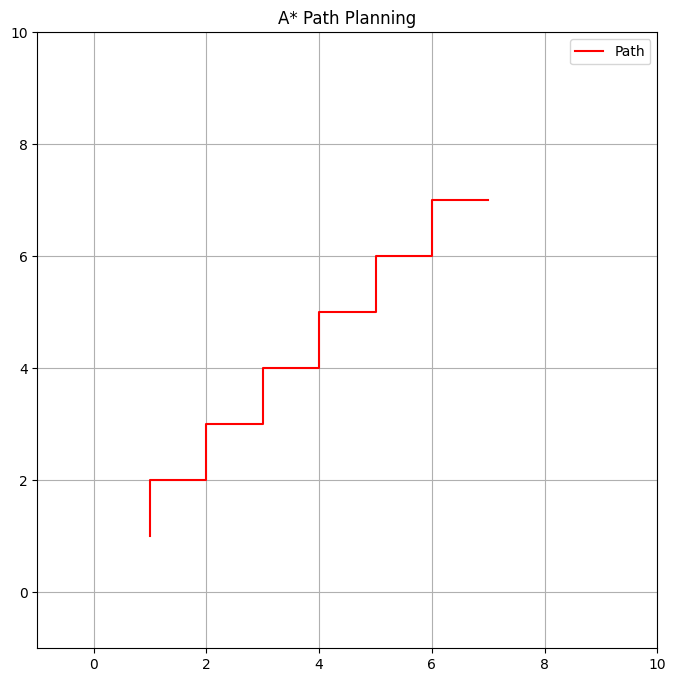

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import heapq


# A* Algorithm
def a_star(start, goal, grid):
    # Helper functions
    grid_size = grid.shape

    def heuristic(a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def get_neighbors(pos):
        neighbors = [
            (0, 1),
            (0, -1),
            (1, 0),
            (-1, 0),
            # (1,1),
            # (-1,-1),
            # (-1,1),
            # (1,-1),
        ]  # 4-way movement
        valid_neighbors = []
        for dx, dy in neighbors:
            newx, newy = pos[0] + dx, pos[1] + dy
            if (
                0 <= newx < grid_size[0]
                and 0 <= newy < grid_size[1]
                and grid[newx, newy] == 0
            ):
                valid_neighbors.append((newx, newy))
        return valid_neighbors

    # Initialization
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    # Algorithm loop
    while frontier:
        current_cost, current = heapq.heappop(frontier)

        if current == goal:
            
            break

        for next in get_neighbors(current):
            new_cost = cost_so_far[current] + 1  # Assuming uniform cost
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                heapq.heappush(frontier, (priority, next))
                came_from[next] = current
        

    # Reconstruct path
    # current = goal
    path = []
    while current != start:
        print("===",current)
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path

def apply_tranformation(pos,offset):
    x,y=pos
    return(int((x + offset)), int((y + offset)))

# Find path
# Grid definition
grid_size = (10, 10)
start_pos = (-4, -4)
goal_pos = (2,2)
grid = np.zeros(grid_size)
obs=[ ]

start_pos=apply_tranformation(start_pos,5)
goal_pos=apply_tranformation(goal_pos,5)
print(goal_pos)
for i in range(len(obs)):
    ob=obs[i]
    obs[i]=apply_tranformation(ob,5)

path = a_star(start_pos, goal_pos, grid)
print(path)
plot_path(path, grid_size)
if len(path)>1:
    start_pos=path[1]
agg_obs=[]
for ob in obs:
    agg_obs.append(ob)
    grid[ob[0],ob[1]]=1
    path = a_star(start_pos, goal_pos, grid)
    print(path)
    plot_path(path, grid_size,obstacles=agg_obs)
    if len(path)>1:
        start_pos=path[1]


In [201]:
x,y=0,0
offset=0.5
pos = (int((x + offset) // 0.1), int((y + offset) // 0.1))

grid=np.zeros((10,10))
neighbours = [
    (0, -1),
    (1, -1),
    (1, 0),
    (1, 1),
    (0, 1),
    (-1, 1),
    (-1, 0),
    (-1, -1),
]

orientation = 90

orientation += 22.5
start_index = int((orientation // 45))
pos=(pos[0],pos[1])
grid[pos]=9
for i in range(start_index, start_index + 5):
    i = i % len(neighbours)
 
    n=neighbours[i]
    xx,yy=pos[0]+n[0],pos[1]+n[1]
    if 0<= xx<grid.shape[0] and  0<= yy<grid.shape[1]:
        grid[xx,yy]=1
    

np.rot90(grid,1)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 9., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [111]:
y=0.15
offset=0.5
y=y+offset
yy=y//0.1
r=y%0.1
print(yy,r,(yy*0.1)+r-offset)


6.0 0.04999999999999999 0.15000000000000013


In [198]:
s=[
    [0,0,0]
]

0

In [203]:
np.degrees(0.1)


np.float64(5.729577951308233)